<a href="https://colab.research.google.com/github/r-iradukunda/Sound_Clustering_assign/blob/main/Sound_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [ ]:
# Importing Library
import os
import numpy as np
import pandas as pd
import seaborn as sns
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the Data
unlabelled_data_path = "/content/drive/MyDrive/clustering/unlabelled_sounds"

features = []

# Extract Features
def extract_feature(file_path, sr=22050, n_mels=128):
    y, sr = librosa.load(file_path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return np.mean(mel_db, axis=1)

# then loop through files and extract features
features = []
file_names = []

for file_name in os.listdir(unlabelled_data_path):
    if file_name.endswith('.wav'):
        file_path = os.path.join(unlabelled_data_path, file_name)
        try:
            mel_feature = extract_feature(file_path)
            features.append(mel_feature)
            file_names.append(file_name)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

# convert to array and scale
features_array = np.array(features)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

print("Final scaled feature matrix shape:", features_scaled.shape)


Final scaled feature matrix shape: (3000, 128)


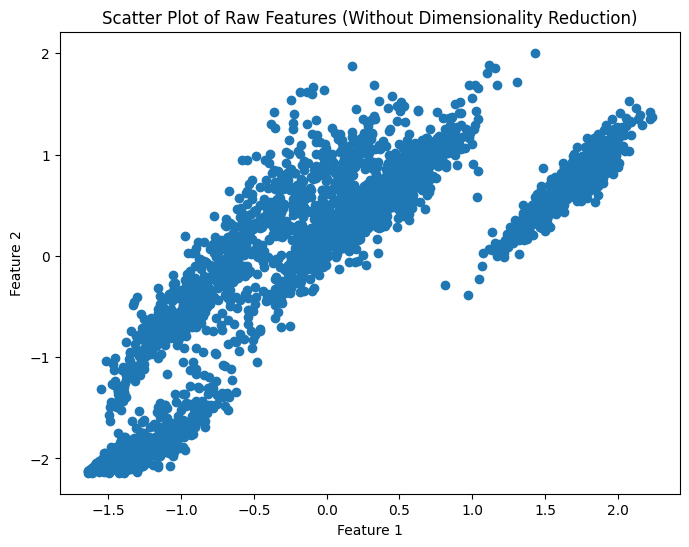

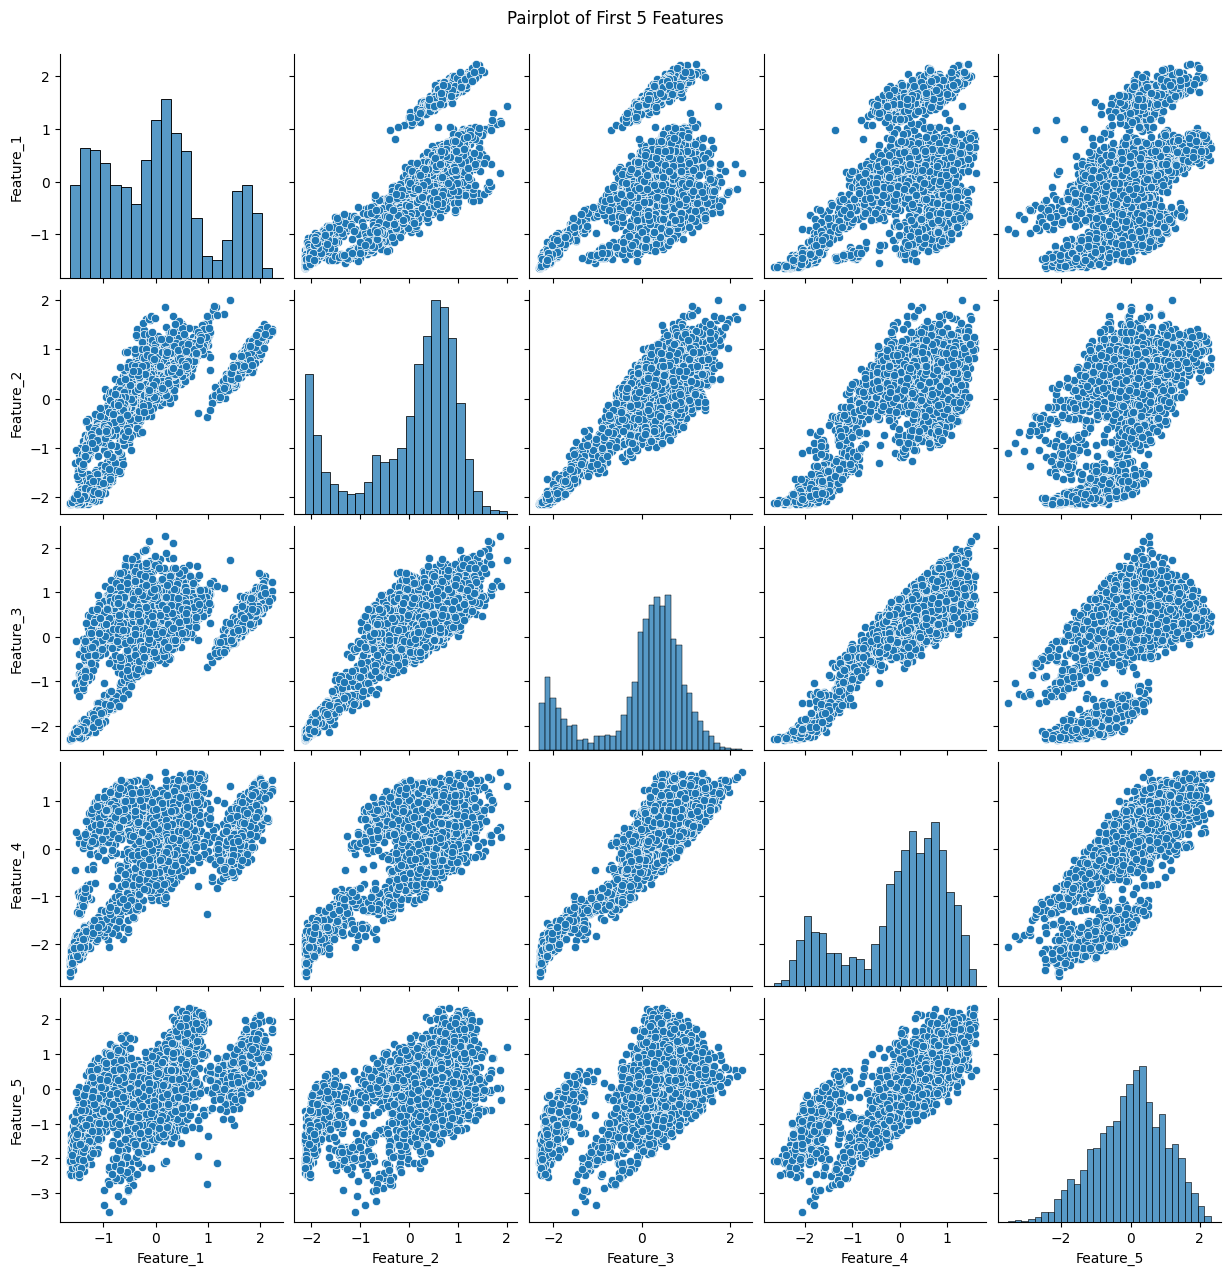

In [ ]:

# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_scaled[:, 0], features_scaled[:, 1])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = pd.DataFrame(features_scaled[:, :5], columns=[f"Feature_{i+1}" for i in range(5)])
sns.pairplot(df)
plt.suptitle("Pairplot of First 5 Features", y=1.02)
plt.show()


### Why is dimensionality reduction important?
(*Document any challenges/errors from the above experiments.*)

Dimensionality reduction is required as the Mel spectrogram features are high-dimensional and make clustering ineffective and hard to visualize. Dimensionality reduction through PCA or t-SNE revealed good structure in the data, improved separation of clusters, and significantly reduced computational cost. In its absence, there was no separation through raw feature scatter plots, and clustering was less effective.

In [ ]:

# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features_scaled)


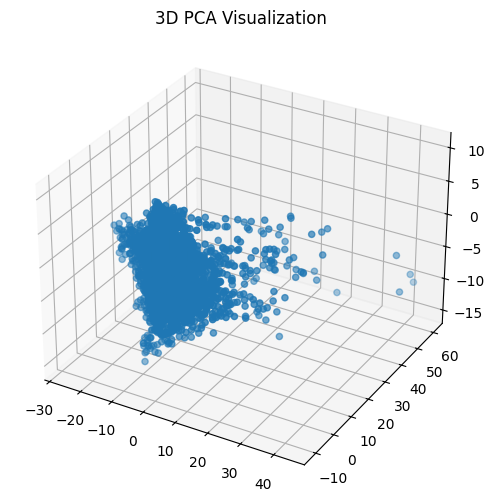

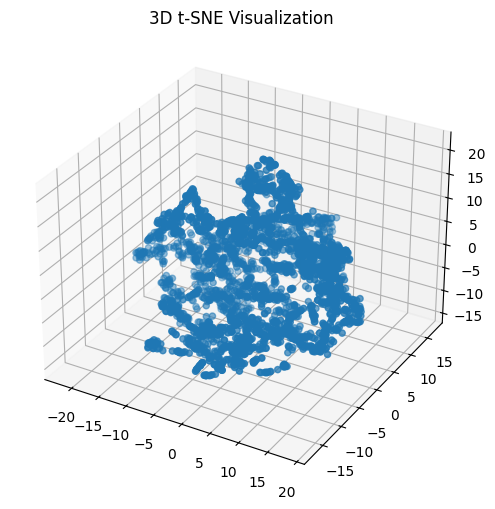

In [ ]:
# Plotting 3D for PCA
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2])
ax.set_title("3D PCA Visualization")
plt.show()

# Plotting 3D for t-SNE
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2])
ax.set_title("3D t-SNE Visualization")
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?
(*Write based on your visualizations.*)

As seen from the 3D scatter plots, t-SNE had better separation between clusters than PCA. Though PCA represented the dominant directions of variance linearly, t-SNE maintained local distances and clustered similar samples more tightly and formed more separable clusters. This rendered cluster boundaries more evident visually.

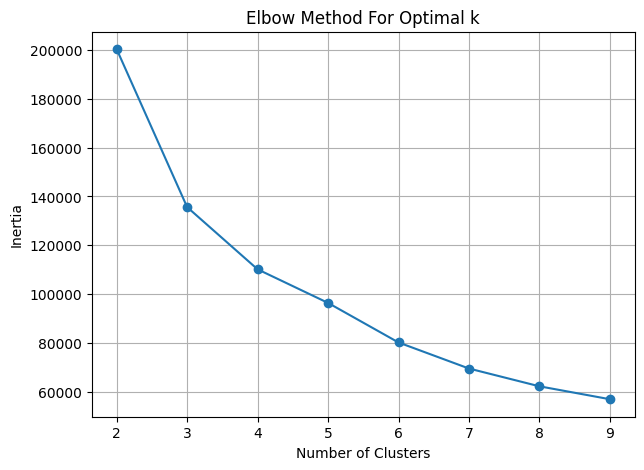

In [ ]:

# Optimize number of clusters using Elbow Method
inertias = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)
    inertias.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(7, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


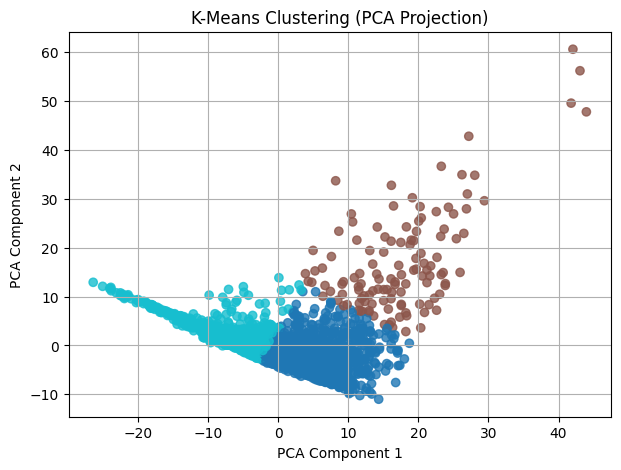

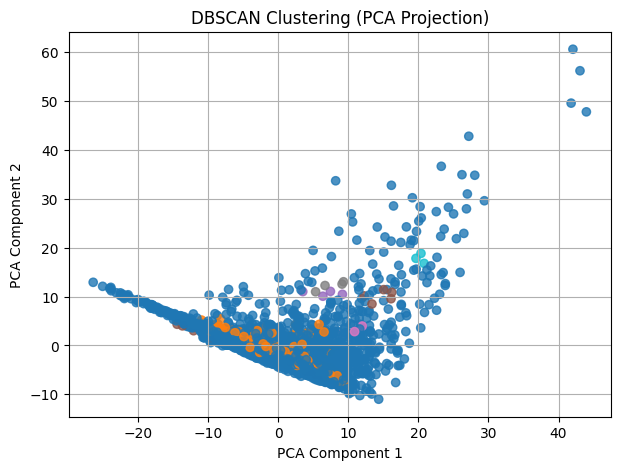

In [ ]:

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_scaled)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(7, 5))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.8)
plt.title('K-Means Clustering (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(7, 5))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='tab10', alpha=0.8)
plt.title('DBSCAN Clustering (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


In [ ]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_scaled, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_scaled, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_scaled, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_scaled, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.2605, Davies-Bouldin Index: 1.2097
DBSCAN - Silhouette Score: -0.2419, Davies-Bouldin Index: 1.9996


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

K-Means showed consistent clustering but was sensitive to the chosen number of clusters and less effective with non-spherical shapes. DBSCAN detected arbitrary-shaped clusters and outliers better but required careful tuning of eps and min_samples. Overall, K-Means produced more stable cluster assignments, while DBSCAN highlighted outliers and denser regions effectively.

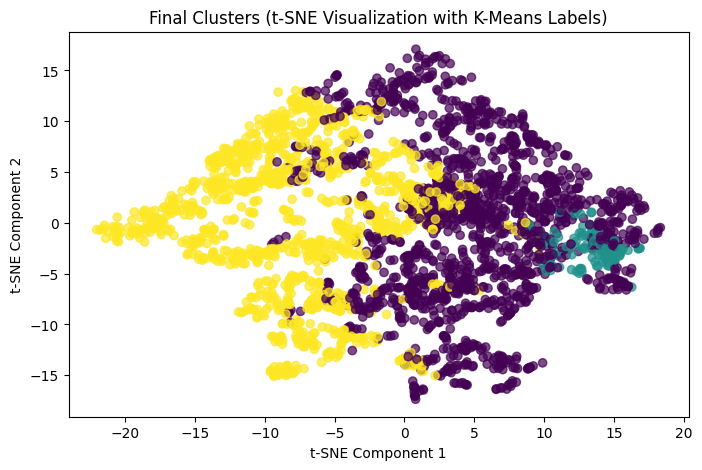

In [ ]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.

Dimensionality reduction was necessary as the original Mel spectrogram feature vectors were not visually distinguishable and high-dimensional. Reducing them to 2 or 3 dimensions using PCA and t-SNE made the structural pattern of the data obvious. This facilitated the ability of clustering algorithms to identify patterns and made visual interpretation of clusters easier.

- Justify why certain clustering methods worked better.

*   K-Means performed well after dimensionality reduction, especially with PCA, because it assumes spherical clusters and benefits from a compact, low-dimensional representation of data.

*   DBSCAN was more sensitive to density and performed better in identifying noise or outliers, particularly with t-SNE, which preserved local neighborhood structures.

K-Means was parameter stable but required to know the number of clusters beforehand. DBSCAN did not need to know the number of clusters beforehand and could detect complex shapes but was parameter-sensitive (eps, min_samples).

- Relate findings to real-world clustering challenges.

In real-world audio clustering, such as sound classification or voice separation, data is noisy, high-dimensional, and unmarked. It must be reduced in dimensionality in order for patterns to be meaningful. Depending on the form of the data, the right clustering algorithm is as follows: K-Means is fast and effective for well-separated clusters, but DBSCAN is better for noisy or irregular data. Both, however, require to be well preprocessed and parameter-tuned to handle the variability inherent in real-world sound data.